At first, we load **libraries with functions needed for analysis** (cobra), dataframe and graph generation, as well as requests for access to open APIs.

In [2]:
import cobra
cobra.Configuration().solver='cplex'
import os
import pickle
import pandas as pd
import matplotlib.pyplot as plt
import mygene
import requests, sys
from Bio import Entrez
from chembl_webresource_client.new_client import new_client

GUROBI is available but could not load with error:
  Traceback (most recent call last):
    File "/usr/local/lib/python3.6/site-packages/optlang/gurobi_interface.py", line 40, in <module>
      raise RuntimeError()
  RuntimeError
  
  During handling of the above exception, another exception occurred:
  
  Traceback (most recent call last):
    File "/usr/local/lib/python3.6/site-packages/optlang/__init__.py", line 49, in <module>
      from optlang import gurobi_interface
    File "/usr/local/lib/python3.6/site-packages/optlang/gurobi_interface.py", line 43, in <module>
      "This version of optlang requires a Gurobi version of 9.5 or above.")
  RuntimeError: This version of optlang requires a Gurobi version of 9.5 or above.


**Loading reaction and model data and information**
- namesBase, namesMM, namesTissues
- Remove the last 7 letters: name = name[:len(name)-7].
- Names is a list of all 49 names
- Two dictionaries: indexModel[model], modelName[index], modelName[index].
- modelBase : generic model Human-GEM
- myGroup[r.id] : name of the subsystem it belongs to
- reactionsIncluded[model] : ids of the reactions of the model

In [3]:
nombresBase=os.listdir("/home/alumno15/modelos/base/")
nombresTejidos=os.listdir("/home/alumno15/modelos/tejidos/")
nombresMM=os.listdir("/home/alumno15/modelos/MM/")

In [4]:
nombres=[]
for nombre in nombresBase:
    if nombre.endswith(".dat"):
        nombres.append(nombre[:len(nombre)-4])
for nombre in nombresTejidos:
    if nombre.endswith(".dat"):
        nombres.append(nombre[:len(nombre)-4])
for nombre in nombresMM:
    if nombre.endswith(".dat"):
        nombres.append(nombre[:len(nombre)-4])

In [5]:
for nombre in nombres:
    print(nombre)

Human-GEM
adipose_tissue
adrenal_gland
bladder
blood
blood_vessel
brain
breast
colon
esophagus
heart
lung
kidney
muscle
nerve
pancreas
pituitary
small_intestine
stomach
vagina
prostate
skin
testis
thyroid
uterus
cervix_uteri
fallopian_tube
liver
ovary
salivary_gland
spleen
ACH_000838
ACH_000889
ACH_000512
ACH_000426
ACH_000436
ACH_000363
ACH_000183
ACH_000204
ACH_000541
ACH_000576
ACH_000588
ACH_000653
ACH_000714
ACH_000658
ACH_000763
ACH_000817
ACH_000821
ACH_000829


In [6]:
nombreModelo={}
indiceModelo={}
for i,modelo in enumerate(nombres):
    nombreModelo[i]=modelo
    indiceModelo[modelo]=i

In [7]:
with open("/home/alumno15/modelos/base/Human-GEM.dat","rb") as f:
    modeloBase=pickle.load(f)

In [8]:
print("Human1 19.0 version model contains:", len(modeloBase.reactions),"reactions,", 
      len(modeloBase.metabolites),"metabolites and",len(modeloBase.genes),"genes")

Human1 19.0 version model contains: 12995 reactions, 8456 metabolites and 2889 genes


In [9]:
print("Human1 19.0 version model contains:", len(modeloBase.groups),"metabolic subsystems")

Human1 19.0 version model contains: 148 metabolic subsystems


In [10]:
for group in modeloBase.groups:
    print(group.name)

 Arachidonic acid metabolism
Acyl-CoA hydrolysis
Acylglycerides metabolism
Alanine, aspartate and glutamate metabolism
Alkaloids biosynthesis
Amino sugar and nucleotide sugar metabolism
Aminoacyl-tRNA biosynthesis
Androgen metabolism
Arachidonic acid metabolism
Arginine and proline metabolism
Artificial reactions
Ascorbate and aldarate metabolism
Beta oxidation of branched-chain fatty acids (mitochondrial)
Beta oxidation of di-unsaturated fatty acids (n-6) (mitochondrial)
Beta oxidation of di-unsaturated fatty acids (n-6) (peroxisomal)
Beta oxidation of even-chain fatty acids (mitochondrial)
Beta oxidation of even-chain fatty acids (peroxisomal)
Beta oxidation of odd-chain fatty acids (mitochondrial)
Beta oxidation of odd-chain fatty acids (peroxisomal)
Beta oxidation of phytanic acid (peroxisomal)
Beta oxidation of poly-unsaturated fatty acids (mitochondrial)
Beta oxidation of unsaturated fatty acids (n-7) (mitochondrial)
Beta oxidation of unsaturated fatty acids (n-7) (peroxisomal)
B

In [11]:
miGrupo={}
for group in modeloBase.groups:
    for r in group.members:
        miGrupo[r.id]=group.name

In [12]:
'''
reaccionesIncluidas={}
for nombre in nombresMM:
    nombre=nombre[:len(nombre)-7]
    with open("/home/alumno15/modelos/MM/"+nombre+".dat","rb") as f:
        modelo=pickle.load(f)
    reaccionesIncluidas[nombre]=set([r.id for r in modelo.reactions])
for nombre in nombresTejidos:
    nombre=nombre[:len(nombre)-7]
    with open("/home/alumno15/modelos/tejidos/"+nombre+".dat","rb") as f:
        modelo=pickle.load(f)
    reaccionesIncluidas[nombre]=set([r.id for r in modelo.reactions])

with open("reaccionesIncluidas.dat","wb") as f:
    pickle.dump(reaccionesIncluidas,f)
'''

with open("reaccionesIncluidas.dat","rb") as f:
    reaccionesIncluidas = pickle.load(f)

**Tools to analyse MCS**
- MCSByTask [model] [task]: dictionary storing MCS of all models classified by metabolic task
- MCSAllTasks [model]: dictionary storing all MCSs of all models without distinguishing by metabolic task

In [13]:
MCSByTask={}
MCSAllTasks={}

for nombre in nombresBase:
    if nombre.endswith(".dat"):
        nombre=nombre[:len(nombre)-4]
        with open("/home/alumno15/MCS/base/"+nombre+"MCS.dat","rb") as f:
            MCS=pickle.load(f)
        todos=set()
        for task in range(57):
            todos.update(MCS[task][0])
        ByTask=[set()]
        for task in range(57):
            ByTask.append(MCS[task][0])
        MCSByTask[nombre]=ByTask
        MCSAllTasks[nombre]=todos 
    
for nombre in nombresTejidos:
    if nombre.endswith(".dat"):
        nombre=nombre[:len(nombre)-4]
        with open("/home/alumno15/MCS/tejidos/"+nombre+"MCS.dat","rb") as f:
            MCS=pickle.load(f)
        todos=set()
        for task in range(57):
            todos.update(MCS[task][0])
        ByTask=[set()]
        for task in range(57):
            ByTask.append(MCS[task][0])
        MCSByTask[nombre]=ByTask
        MCSAllTasks[nombre]=todos
    
for nombre in nombresMM:
    if nombre.endswith(".dat"):
        nombre=nombre[:len(nombre)-4]
        with open("/home/alumno15/MCS/MM/"+nombre+"MCS.dat","rb") as f:
            MCS=pickle.load(f)
        todos=set()
        for task in range(57):
            todos.update(MCS[task][0])
        ByTask=[set()]
        for task in range(57):
            ByTask.append(MCS[task][0])
        MCSByTask[nombre]=ByTask
        MCSAllTasks[nombre]=todos

**MCSs results for each model, first base model (Human-GEM), then healthy tissues and then MM lines**

tasksUsadas=set()
tasks={}
for i in range(0,1):
    reactions=[r for r in MCSAllTasks[nombreModelo[i]] if r.startswith("MAR")]
    tasks[nombreModelo[i]]={}
    for reaction in reactions:
        tasks[nombreModelo[i]][reaction]=set()
        for task in range(58):
            if reaction in MCSByTask[nombreModelo[i]][task]:
                tasks[nombreModelo[i]][reaction].add(task)
                tasksUsadas.add(task)
        print(nombreModelo[i],reaction,tasks[nombreModelo[i]][reaction])
    tasksUsadas=list(tasksUsadas)
    tasksUsadas.sort()
    print("Model:",nombreModelo[i],"|","Total MCS:",len(MCSAllTasks[nombreModelo[i]]),"|","Tasks:",tasksUsadas)

comunes=set()
for reaccion in reactions:
    if len(tasks[nombreModelo[0]][reaccion])>10:
        comunes.add(reaccion)

for r in comunes:
    reaccion=modeloBase.reactions.get_by_id(r)
    print(reaccion,len(tasks[nombreModelo[0]][r]))
    for m in reaccion.metabolites:
        print(m.name)
    print()

entradasComunes=set(r for r in comunes if len(modeloBase.reactions.get_by_id(r).metabolites)<=2)
len(entradasComunes)

tasksUsadas=set()
tasks={}
for i in range(0,1):
    reactions=[r for r in MCSAllTasks[nombreModelo[i]] if r.startswith("MAR")]
    tasks[nombreModelo[i]]={}
    for reaction in set(reactions).difference(entradasComunes):
        tasks[nombreModelo[i]][reaction]=set()
        for task in range(58):
            if reaction in MCSByTask[nombreModelo[i]][task]:
                tasks[nombreModelo[i]][reaction].add(task)
                tasksUsadas.add(task)
        print(reaction,nombreModelo[i],tasks[nombreModelo[i]][reaction])
    tasksUsadas=list(tasksUsadas)
    tasksUsadas.sort()
    print("Model:",nombreModelo[i],"|","Total MCS:",len(MCSAllTasks[nombreModelo[i]]),"|","Tasks:",tasksUsadas)

In [14]:
genericas=MCSAllTasks[nombreModelo[0]]
print("Number of MCSs in the generic model:",len(genericas))

Number of MCSs in the generic model: 441


In [15]:
for i in range(1,31):
    MCS_tissues=MCSAllTasks[nombreModelo[i]]
    print("Model:",nombreModelo[i],"|","Total MCS:",len(MCS_tissues),"|",len(MCS_tissues.difference(genericas)))

Model: adipose_tissue | Total MCS: 638 | 197
Model: adrenal_gland | Total MCS: 612 | 171
Model: bladder | Total MCS: 664 | 223
Model: blood | Total MCS: 637 | 196
Model: blood_vessel | Total MCS: 682 | 241
Model: brain | Total MCS: 646 | 205
Model: breast | Total MCS: 715 | 274
Model: colon | Total MCS: 623 | 182
Model: esophagus | Total MCS: 642 | 201
Model: heart | Total MCS: 626 | 185
Model: lung | Total MCS: 671 | 230
Model: kidney | Total MCS: 657 | 216
Model: muscle | Total MCS: 717 | 276
Model: nerve | Total MCS: 680 | 239
Model: pancreas | Total MCS: 598 | 157
Model: pituitary | Total MCS: 628 | 187
Model: small_intestine | Total MCS: 595 | 154
Model: stomach | Total MCS: 612 | 171
Model: vagina | Total MCS: 698 | 257
Model: prostate | Total MCS: 635 | 194
Model: skin | Total MCS: 688 | 247
Model: testis | Total MCS: 612 | 171
Model: thyroid | Total MCS: 667 | 226
Model: uterus | Total MCS: 729 | 288
Model: cervix_uteri | Total MCS: 654 | 213
Model: fallopian_tube | Total MCS: 

In [16]:
for i in range(31,49):
    MCS_MMlines=MCSAllTasks[nombreModelo[i]]
    print("Model:",nombreModelo[i],"|","Total MCS:",len(MCS_MMlines),"|",len(MCS_MMlines.difference(genericas)))

Model: ACH_000838 | Total MCS: 784 | 343
Model: ACH_000889 | Total MCS: 702 | 261
Model: ACH_000512 | Total MCS: 710 | 269
Model: ACH_000426 | Total MCS: 619 | 178
Model: ACH_000436 | Total MCS: 677 | 236
Model: ACH_000363 | Total MCS: 683 | 242
Model: ACH_000183 | Total MCS: 711 | 270
Model: ACH_000204 | Total MCS: 636 | 195
Model: ACH_000541 | Total MCS: 670 | 229
Model: ACH_000576 | Total MCS: 647 | 206
Model: ACH_000588 | Total MCS: 676 | 235
Model: ACH_000653 | Total MCS: 709 | 268
Model: ACH_000714 | Total MCS: 643 | 202
Model: ACH_000658 | Total MCS: 670 | 229
Model: ACH_000763 | Total MCS: 680 | 239
Model: ACH_000817 | Total MCS: 713 | 272
Model: ACH_000821 | Total MCS: 620 | 179
Model: ACH_000829 | Total MCS: 663 | 222


**Toxicity studies (MCSs that affect healthy tissues)**
- modelsAffected[r.id] : list of tissues affected by some MCSs
- numeroModelosAfectados[r.id] : list of the ‘number’ of tissues affected by some MCSs
- Level1,..., Level5: toxicity levels
- generic: MCS of the base model
- someModel: MCSs which block some tissue
- specific: MCSs which block some tissue and are not generic

In [17]:
algunModelo=set()
for i in range(1,31):
    especificasTask=MCSAllTasks[nombreModelo[i]]
    algunModelo.update(especificasTask)
print("Number of MCSs in some healthy tissue model:",len(algunModelo))

Number of MCSs in some healthy tissue model: 912


In [18]:
especificas=algunModelo.difference(genericas)
print("Number of MCSs specific to healthy tissue models:",len(especificas))

Number of MCSs specific to healthy tissue models: 471


In [19]:
numeroModelosAfectados={}
modelosAfectados={}
for r in especificas:
    afectados=set()
    for i in range(1,31):
        if r in MCSAllTasks[nombreModelo[i]]:
            afectados.add(nombreModelo[i])
    numeroModelosAfectados[r]=len(afectados)
    modelosAfectados[r]=afectados

In [20]:
Nivel1T=[r for r in numeroModelosAfectados if numeroModelosAfectados[r]<5]
Nivel2T=[r for r in numeroModelosAfectados if numeroModelosAfectados[r]<10]
for i in range(31,49):
    buenosMM=MCSAllTasks[nombreModelo[i]].intersection(Nivel1T)
    notanbuenosMM=MCSAllTasks[nombreModelo[i]].intersection(Nivel2T)
    print("Model name",nombreModelo[i],"Total MCS",len(MCSAllTasks[nombreModelo[i]]),"MCS low tox",len(buenosMM),"MCS middle tox",len(notanbuenosMM))

Model name ACH_000838 Total MCS 784 MCS low tox 26 MCS middle tox 40
Model name ACH_000889 Total MCS 702 MCS low tox 15 MCS middle tox 28
Model name ACH_000512 Total MCS 710 MCS low tox 36 MCS middle tox 55
Model name ACH_000426 Total MCS 619 MCS low tox 13 MCS middle tox 27
Model name ACH_000436 Total MCS 677 MCS low tox 10 MCS middle tox 24
Model name ACH_000363 Total MCS 683 MCS low tox 26 MCS middle tox 76
Model name ACH_000183 Total MCS 711 MCS low tox 33 MCS middle tox 51
Model name ACH_000204 Total MCS 636 MCS low tox 13 MCS middle tox 29
Model name ACH_000541 Total MCS 670 MCS low tox 6 MCS middle tox 19
Model name ACH_000576 Total MCS 647 MCS low tox 15 MCS middle tox 33
Model name ACH_000588 Total MCS 676 MCS low tox 8 MCS middle tox 22
Model name ACH_000653 Total MCS 709 MCS low tox 16 MCS middle tox 43
Model name ACH_000714 Total MCS 643 MCS low tox 19 MCS middle tox 32
Model name ACH_000658 Total MCS 670 MCS low tox 9 MCS middle tox 23
Model name ACH_000763 Total MCS 680 M

In [21]:
todas=set([r.id for r in modeloBase.reactions])

In [22]:
Nivel1T=[numeroModelosAfectados[r] for r in numeroModelosAfectados if numeroModelosAfectados[r]<5]
Nivel2T=[numeroModelosAfectados[r] for r in numeroModelosAfectados if 5<=numeroModelosAfectados[r]<10]
Nivel3T=[numeroModelosAfectados[r] for r in numeroModelosAfectados if 10<=numeroModelosAfectados[r]<19]
Nivel4T=[numeroModelosAfectados[r] for r in numeroModelosAfectados if 20<=numeroModelosAfectados[r]<30]
Nivel5T=[numeroModelosAfectados[r] for r in numeroModelosAfectados if numeroModelosAfectados[r]==30]

In [23]:
print("Nivel 0:",len(todas.difference(genericas.union(especificas))), "mata 0 tejidos")
print("Nivel 1:",len(Nivel1T), "mata 1-4 tejidos")
print("Nivel 2:",len(Nivel2T), "mata 5-9 tejidos")
print("Nivel 3:",len(Nivel3T), "mata 10-19 tejidos")
print("Nivel 4:",len(Nivel4T), "mata 20-29 tejidos")
print("Nivel 5:",len(Nivel5T), "mata 30 tejidos")

Nivel 0: 12093 mata 0 tejidos
Nivel 1: 106 mata 1-4 tejidos
Nivel 2: 95 mata 5-9 tejidos
Nivel 3: 121 mata 10-19 tejidos
Nivel 4: 53 mata 20-29 tejidos
Nivel 5: 87 mata 30 tejidos


     Nivel         Descripción  Cantidad
0  Level 1    kill 1-4 tissues       106
1  Level 2    kill 5-9 tissues        95
2  Level 3  kill 10-19 tissues       121
3  Level 4  kill 20-29 tissues        53
4  Level 5     kill 30 tissues        87


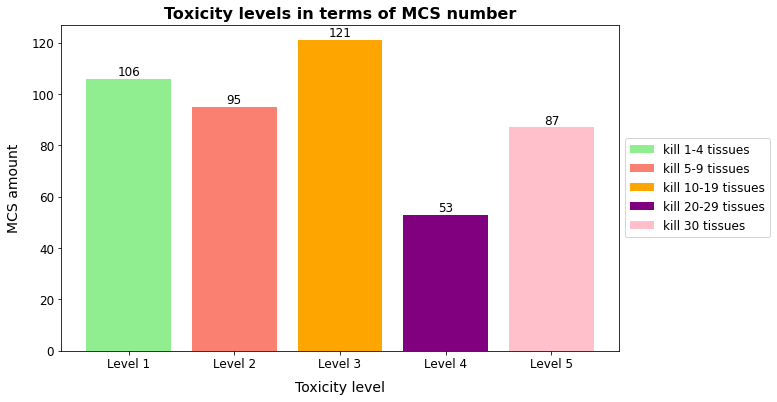

In [24]:
toxicitydata = {
    "Nivel": ["Level 1", "Level 2", "Level 3", "Level 4", "Level 5"],
    "Descripción": ["kill 1-4 tissues", "kill 5-9 tissues", "kill 10-19 tissues", "kill 20-29 tissues", "kill 30 tissues"],
    "Cantidad": [
        len(Nivel1T),
        len(Nivel2T),
        len(Nivel3T),
        len(Nivel4T),
        len(Nivel5T)
    ]
}

df_tox = pd.DataFrame(toxicitydata)
print(df_tox)
colors = ['lightgreen', 'salmon', 'orange', 'purple', 'pink']

plt.figure(figsize=(10, 6))
bars = plt.bar(df_tox['Nivel'], df_tox['Cantidad'], color=colors)
#Añadir leyenda
for bar, desc in zip(bars, df_tox['Descripción']):
    bar.set_label(desc)
plt.legend(fontsize=12,loc='center left', bbox_to_anchor=(1, 0.5))

plt.xlabel('Toxicity level',fontsize=14,labelpad=10)
plt.ylabel('MCS amount',fontsize=14,labelpad=10)
plt.title('Toxicity levels in terms of MCS number', fontweight='bold',fontsize=16)

#Añadir etiquetas de cantidad encima de las barras
for i, v in enumerate(df_tox['Cantidad']):
    plt.text(i, v + 0.2, str(v), ha='center', va='bottom',fontsize=12)
    
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)


plt.savefig("/home/alumno15/notebooks-tfm-javi/toxicity_levels_ajustada.png", bbox_inches="tight", dpi=300, pad_inches=0.1)
plt.show()

**Target studies (MCSs that affect MM lines)**
- modelsMMAffected[r.id] : list of MM lines affected by some MCSs
- numberMMAffectedModels[r.id]: list with the number of toxicities MM lines
- Level1,..., Level5: level of scope MM
- generic: MCS of the base model
- someModelMM: MCSs which block some line
- specificMM: MCSs which block some line and are not generic

In [25]:
algunModeloMM=set()
for i in range(31,49):
    especificasTask=MCSAllTasks[nombreModelo[i]]
    algunModeloMM.update(especificasTask)
print("Number of MCSs in some MM line model:",len(algunModeloMM))

Number of MCSs in some MM line model: 972


In [26]:
especificasMM=algunModeloMM.difference(genericas)
print("Number of MCSs specific to MM line models:",len(especificasMM))

Number of MCSs specific to MM line models: 531


In [27]:
numeroModelosMMAfectados={}
modelosMMAfectados={}
for r in especificasMM:
    afectados=set()
    for i in range(31,49):
        if r in MCSAllTasks[nombreModelo[i]]:
            afectados.add(nombreModelo[i])
    numeroModelosMMAfectados[r]=len(afectados)
    modelosMMAfectados[r]=afectados
    
# Ampliamos modelosAfectados y numeroModelosAfectados para incluir estas
for r in especificasMM:
    if not r in modelosAfectados:
        numeroModelosAfectados[r]=0
        modelosAfectados[r]=set()

In [28]:
Nivel1M=[numeroModelosMMAfectados[r] for r in numeroModelosMMAfectados if numeroModelosMMAfectados[r]<5]
Nivel2M=[numeroModelosMMAfectados[r] for r in numeroModelosMMAfectados if 5<=numeroModelosMMAfectados[r]<10]
Nivel3M=[numeroModelosMMAfectados[r] for r in numeroModelosMMAfectados if 10<=numeroModelosMMAfectados[r]<18]
Nivel4M=[numeroModelosMMAfectados[r] for r in numeroModelosMMAfectados if numeroModelosMMAfectados[r]==18]

In [29]:
print("Nivel 1:",len(Nivel1M),"mata < 5 líneas")
print("Nivel 2:",len(Nivel2M),"mata 5-9 líneas")
print("Nivel 3:",len(Nivel3M),"mata 10-17 líneas")
print("Nivel 4:",len(Nivel4M),"mata 18 líneas")

Nivel 1: 237 mata < 5 líneas
Nivel 2: 70 mata 5-9 líneas
Nivel 3: 134 mata 10-17 líneas
Nivel 4: 90 mata 18 líneas


     Nivel       Descripción  Cantidad
0  Level 1    kill < 5 lines       237
1  Level 2    kill 5-9 lines        70
2  Level 3  kill 10-17 lines       134
3  Level 4     kill 18 lines        90


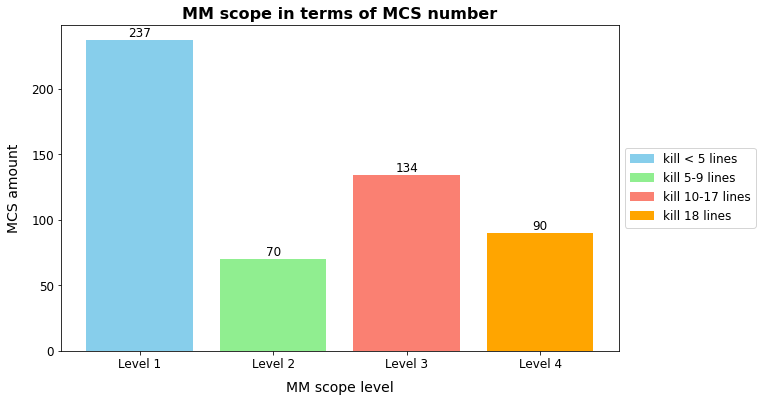

In [30]:
MMleveldata = {
    "Nivel": ["Level 1", "Level 2", "Level 3", "Level 4"],
    "Descripción": ["kill < 5 lines", "kill 5-9 lines", "kill 10-17 lines", "kill 18 lines"],
    "Cantidad": [
        len(Nivel1M),
        len(Nivel2M),
        len(Nivel3M),
        len(Nivel4M)
    ]
}

df_MM = pd.DataFrame(MMleveldata)
print(df_MM)
colors = ['skyblue', 'lightgreen', 'salmon', 'orange']

plt.figure(figsize=(10, 6))
bars = plt.bar(df_MM['Nivel'], df_MM['Cantidad'], color=colors)
for bar, desc in zip(bars, df_MM['Descripción']):
    bar.set_label(desc)
plt.legend(fontsize=12,loc='center left', bbox_to_anchor=(1, 0.5))

plt.xlabel('MM scope level',fontsize=14,labelpad=10)
plt.ylabel('MCS amount',fontsize=14,labelpad=10)
plt.title('MM scope in terms of MCS number', fontweight='bold',fontsize=16)

for i, v in enumerate(df_MM['Cantidad']):
    plt.text(i, v + 0.2, str(v), ha='center', va='bottom',fontsize=12)

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.savefig("/home/alumno15/notebooks-tfm-javi/MMscope_levels_ajustada.png", bbox_inches="tight", dpi=300, pad_inches=0.1)
plt.show()

**Target analysis for all or various lines**
- general: block all lines
- good: kill more than 10 lines and have less than 5 toxicities

In [31]:
generales=set(r for r in numeroModelosMMAfectados if numeroModelosMMAfectados[r]==18)

In [32]:
cont=0
for r in generales:
    if numeroModelosAfectados[r]<30:
        print(r,numeroModelosAfectados[r], "healthy tissues affected")
    else:
        cont+=1
print()
print("Along with",cont,"almost generic toxicities")

MAR00361 29 healthy tissues affected
MAR09064 24 healthy tissues affected
MAR04894 18 healthy tissues affected
MAR01437 27 healthy tissues affected
MAR09378 25 healthy tissues affected
MAR01506 25 healthy tissues affected
MAR06636 25 healthy tissues affected
MAR04969 25 healthy tissues affected
MAR04059 17 healthy tissues affected
MAR07794 29 healthy tissues affected
MAR00313 29 healthy tissues affected
MAR05127 25 healthy tissues affected
MAR05128 25 healthy tissues affected
MAR02960 28 healthy tissues affected
MAR02993 28 healthy tissues affected
MAR04954 28 healthy tissues affected

Along with 74 almost generic toxicities


Of the MCSs that kill less than 20 healthy tissues, we show IDs of those MCSs and which tissues they kill

In [33]:
for r in generales:
    if numeroModelosAfectados[r]<20:
        print(r)
        print(modelosAfectados[r])
        print()
        

MAR04894
{'small_intestine', 'thyroid', 'salivary_gland', 'kidney', 'spleen', 'fallopian_tube', 'nerve', 'heart', 'colon', 'blood_vessel', 'adipose_tissue', 'esophagus', 'stomach', 'blood', 'bladder', 'skin', 'muscle', 'lung'}

MAR04059
{'thyroid', 'salivary_gland', 'kidney', 'spleen', 'uterus', 'testis', 'colon', 'cervix_uteri', 'liver', 'esophagus', 'brain', 'stomach', 'blood', 'bladder', 'ovary', 'muscle', 'lung'}



None of them seem interesting. We move on to common cut sets for many lines.
We set as ‘good’ targets those that kill at most 5 different tissues and kill at least 10 MM lines.

In [34]:
minLineasMieloma = 10
maxLineasTejido=5

buenos=[r for r in numeroModelosMMAfectados if numeroModelosMMAfectados[r]>=minLineasMieloma and ((not r in especificas) or numeroModelosAfectados[r]<= maxLineasTejido)]
print("Good reactions:",len(buenos),"kill at least 10 MM lines and not affect more than 5 healthy tissues")

Good reactions: 7 kill at least 10 MM lines and not affect more than 5 healthy tissues


We obtain 7 reactions that comply with the filter and see how many toxicities are associated with each of them, how many lines they kill and the subsystem to which they belong.

In [35]:
for r in buenos:
    afecta=numeroModelosAfectados[r]
    print(r,"Toxicidades",afecta,"Lineas MM mata",numeroModelosMMAfectados[r],"Grupo",miGrupo[r]) 

MAR06644 Toxicidades 1 Lineas MM mata 15 Grupo Retinol metabolism
MAR04623 Toxicidades 0 Lineas MM mata 16 Grupo Pentose phosphate pathway
MAR04473 Toxicidades 0 Lineas MM mata 14 Grupo Pentose phosphate pathway
MAR06660 Toxicidades 1 Lineas MM mata 17 Grupo Retinol metabolism
MAR06386 Toxicidades 0 Lineas MM mata 12 Grupo Transport reactions
MAR08702 Toxicidades 1 Lineas MM mata 15 Grupo Retinol metabolism
MAR02598 Toxicidades 0 Lineas MM mata 12 Grupo Carnitine shuttle (mitochondrial)


We show that all existing toxicities belong to the same subsystem: retinol metabolism.

In [36]:
for r in buenos:
    if numeroModelosAfectados[r]>0:
        print(r,miGrupo[r],modelosAfectados[r])

MAR06644 Retinol metabolism {'blood'}
MAR06660 Retinol metabolism {'blood'}
MAR08702 Retinol metabolism {'blood'}


**Remarks**
- They seem interesting, they all have 1 or no toxicity, being always blood toxicity and always associated with reactions belonging to the retinol metabolism subsystem.
- They all kill more than 12 MM lines and are dominated by the pentose phosphate pathway, retinal metabolism, carnitine metabolism at the mitochondrial level and a transport reaction containing glucose-6-phosphate and Pi as metabolites.

**Quality check of good MCSs**
- We check that the fact that these 7 good reactions kill that number of MM lines is because they do and not because they are not present in the rest of the lines.
  lines is because it really happens and not because they are not present in the rest of the lines.
- We found two of them where it would probably be cutset of the 18, if they were in all lines.

In [37]:
for r in buenos:
    noContiene=set(nombre for nombre in nombres if "ACH" in nombre and not r in reaccionesIncluidas[nombre])
    print(r,miGrupo[r],len(modelosMMAfectados[r]),len(modelosMMAfectados[r].union(noContiene)))

MAR06644 Retinol metabolism 15 15
MAR04623 Pentose phosphate pathway 16 16
MAR04473 Pentose phosphate pathway 14 14
MAR06660 Retinol metabolism 17 18
MAR06386 Transport reactions 12 18
MAR08702 Retinol metabolism 15 18
MAR02598 Carnitine shuttle (mitochondrial) 12 12


**Is there a way to expand the number of lines we can kill without increasing the number of toxicities?**
- We work with pairs of reactions, i.e. pairs formed by two good reactions.

In [38]:
for i,r1 in enumerate(buenos):
    for j,r2 in enumerate(buenos):
        if i>j:
            matan=len(modelosMMAfectados[r1].union(modelosMMAfectados[r2]))
            if matan==18:
                print(r1,r2,matan)
                print(miGrupo[r1],miGrupo[r2])
                efectos1=0
                efectos2=0
                if r1 in numeroModelosAfectados:
                    efectos1=numeroModelosAfectados[r1]
                if r2 in numeroModelosAfectados:
                    efectos2=numeroModelosAfectados[r2]
                print(efectos1,efectos2)
                print()

MAR04623 MAR06644 18
Pentose phosphate pathway Retinol metabolism
0 1

MAR06660 MAR04623 18
Retinol metabolism Pentose phosphate pathway
1 0

MAR06660 MAR04473 18
Retinol metabolism Pentose phosphate pathway
1 0

MAR08702 MAR04623 18
Retinol metabolism Pentose phosphate pathway
1 0



**Search for genes and metabolites involved in good MCSs**.
- Search and addition of all GPR rules in a dictionary called genes.
- Search and addition of the ID and the name of the reaction-forming metabolites for each good reaction.
- ID scanning of different gene databases (Entrez, Symbol and name) by accessing the corresponding API endpoint.

In [39]:
genes=dict()
for r in modeloBase.reactions:
    if len(r.genes)==0:
        genes[r.id]=set()
    if len(r.genes)==1:
        genes[r.id]=set([g.id for g in r.genes])
    if len(r.genes)>=2:
        exp=r.gene_reaction_rule
        if "and" in exp and not "or" in exp:
            genes[r.id]=set([g.id for g in r.genes])
        if "or" in exp and not "and" in exp:
            genes[r.id]=set([g.id for g in r.genes])
        if "and" in exp and "or" in exp:
            genes[r.id]=set([g.id for g in r.genes]) 

In [40]:
metabolites = dict()
names_met = dict()
for r in modeloBase.reactions:
    metabolite_list = [metabolite.id for metabolite in r.metabolites]
    met_names = [metabolite.name for metabolite in r.metabolites]
    metabolites[r.id] = metabolite_list
    names_met[r.id] = met_names

In [41]:
genes_interes = []
nombres_metabolitos_unicos = set() 

for r in buenos:
    print(r, "Genes asociados", genes[r])
    genes_interes.append(genes[r])
    print("Metabolitos asociados", metabolites[r])
    print("Metabolitos names", names_met[r])
    nombres_metabolitos_unicos.update(names_met[r]) 
    print()
    print()

nombres_metabolitos_unicos_lista = list(nombres_metabolitos_unicos)

MAR06644 Genes asociados {'ENSG00000187630', 'ENSG00000265203', 'ENSG00000170786', 'ENSG00000198099', 'ENSG00000135437', 'ENSG00000025423', 'ENSG00000139547', 'ENSG00000140522', 'ENSG00000157326'}
Metabolitos asociados ['MAM01230c', 'MAM02039c', 'MAM02553c', 'MAM01232c', 'MAM02552c']
Metabolitos names ['9-cis-retinal', 'H+', 'NADH', '9-cis-retinol', 'NAD+']


MAR04623 Genes asociados {'ENSG00000049239'}
Metabolitos asociados ['MAM01961r', 'MAM02040r', 'MAM01169r', 'MAM02039r']
Metabolitos names ['glucono-1,5-lactone-6-phosphate', 'H2O', '6-phospho-D-gluconate', 'H+']


MAR04473 Genes asociados {'ENSG00000142657'}
Metabolitos asociados ['MAM01169r', 'MAM02554r', 'MAM01596r', 'MAM02555r', 'MAM02846r']
Metabolitos names ['6-phospho-D-gluconate', 'NADP+', 'CO2', 'NADPH', 'ribulose-5-phosphate']


MAR06660 Genes asociados set()
Metabolitos asociados ['MAM01231r', 'MAM02833r']
Metabolitos names ['9-cis-retinoate', 'retinoate']


MAR06386 Genes asociados {'ENSG00000281500'}
Metabolitos asocia

In [42]:
for elemento in genes_interes[:]:  
    if isinstance(elemento, set) and not elemento:
        genes_interes.remove(elemento)
print(genes_interes)

[{'ENSG00000187630', 'ENSG00000265203', 'ENSG00000170786', 'ENSG00000198099', 'ENSG00000135437', 'ENSG00000025423', 'ENSG00000139547', 'ENSG00000140522', 'ENSG00000157326'}, {'ENSG00000049239'}, {'ENSG00000142657'}, {'ENSG00000281500'}, {'ENSG00000095321', 'ENSG00000157184'}]


In [43]:
genes_a_buscar = [gene for conjunto in genes_interes for gene in conjunto]
mg = mygene.MyGeneInfo()
df = mg.querymany(genes_a_buscar, scopes='ensembl.gene', species=9606, as_dataframe=True)
df.iloc[:, [2, 3, 4]]

,entrezgene,name,symbol
query,,,
ENSG00000187630,317749,dehydrogenase/reductase 4 like 2,DHRS4L2
ENSG00000265203,5949,retinol binding protein 3,RBP3
ENSG00000170786,195814,short chain dehydrogenase/reductase family 16C...,SDR16C5
ENSG00000198099,127,"alcohol dehydrogenase 4 (class II), pi polypep...",ADH4
ENSG00000135437,5959,retinol dehydrogenase 5,RDH5
ENSG00000025423,8630,hydroxysteroid 17-beta dehydrogenase 6,HSD17B6
ENSG00000139547,8608,retinol dehydrogenase 16,RDH16
ENSG00000140522,6017,retinaldehyde binding protein 1,RLBP1
ENSG00000157326,10901,dehydrogenase/reductase 4,DHRS4


In [44]:
symbol_dict={}
for g in genes_a_buscar:
    gene = mg.getgene(g, fields='symbol')
    if "symbol" in gene:
        symbol_dict[g]= gene["symbol"]

**Drug search for diseases, genes and coincidences**
- We access the chEMBL API endpoint and retrieve any molecule that has activity against our genes of interest that control the most promising reactions (MCSs).
- The idea is to see if we can propose a drug that attacks our therapeutic targets in a way that might be interesting to explore our results experimentally.

**Get approved drugs for MM**

In [45]:
drug_indication = new_client.drug_indication
molecules = new_client.molecule

MM_ind = drug_indication.filter(efo_term__icontains="MULTIPLE MYELOMA")
MM_mols = molecules.filter(
    molecule_chembl_id__in=[x['molecule_chembl_id'] for x in MM_ind])

len(MM_mols)

436

**Get approved drugs for cancer** *(Note: it will take a few minutes)*

In [46]:
drug_indication = new_client.drug_indication
molecules = new_client.molecule

cancer_ind = drug_indication.filter(efo_term__icontains="CANCER")
cancer_mols = molecules.filter(
    molecule_chembl_id__in=[x['molecule_chembl_id'] for x in cancer_ind])

len(cancer_mols)

1734

In [47]:
df_MM_mols = pd.DataFrame(MM_mols)
print("\nColumnas del DataFrame:")
print(df_MM_mols.columns)


Columnas del DataFrame:
Index(['atc_classifications', 'availability_type', 'biotherapeutic',
       'black_box_warning', 'chebi_par_id', 'chemical_probe', 'chirality',
       'cross_references', 'dosed_ingredient', 'first_approval',
       'first_in_class', 'helm_notation', 'indication_class', 'inorganic_flag',
       'max_phase', 'molecule_chembl_id', 'molecule_hierarchy',
       'molecule_properties', 'molecule_structures', 'molecule_synonyms',
       'molecule_type', 'natural_product', 'oral', 'orphan', 'parenteral',
       'polymer_flag', 'pref_name', 'prodrug', 'structure_type',
       'therapeutic_flag', 'topical', 'usan_stem', 'usan_stem_definition',
       'usan_substem', 'usan_year', 'withdrawn_flag'],
      dtype='object')


In [48]:
df_MM_pref_name = df_MM_mols[['pref_name']]
df_MM_pref_name

,pref_name
0,FENRETINIDE
1,SIROLIMUS
2,TACROLIMUS ANHYDROUS
3,ASPIRIN
4,PROPRANOLOL
...,...
431,SONROTOCLAX
432,ALTEMINOSTAT
433,ABBV-383
434,KEYHOLE LIMPET HEMOCYANIN


In [49]:
df_cancer_mols = pd.DataFrame(cancer_mols)
df_cancer_pref_name = df_cancer_mols[['pref_name']]
df_cancer_pref_name

,pref_name
0,NICOTINE
1,INDOMETHACIN
2,CIPROFLOXACIN
3,IMIPRAMINE
4,BICALUTAMIDE
...,...
1729,SUVEMCITUG
1730,ENLONSTOBART
1731,BENMELSTOBART
1732,AUTOLOGOUS PERIPHERAL-BLOOD MONONUCLEAR CELLS ...


In [50]:
df_coincidencias_diseases = pd.merge(df_MM_pref_name, df_cancer_pref_name, on="pref_name")
print("\nDataFrame disease matches between cancer y MM in particular:")
df_coincidencias_diseases


DataFrame disease matches between cancer y MM in particular:


,pref_name
0,FENRETINIDE
1,SIROLIMUS
2,TACROLIMUS ANHYDROUS
3,ASPIRIN
4,PROPRANOLOL
...,...
288,BELRESTOTUG
289,MECAPEGFILGRASTIM
290,XL-999
291,SONROTOCLAX


In [51]:
df_outer = pd.merge(df_MM_pref_name, df_cancer_pref_name, on="pref_name", how="outer", indicator=True)
print("\nDataFrame combined with indicator:")
df_outer


DataFrame combined with indicator:


,pref_name,_merge
0,FENRETINIDE,both
1,SIROLIMUS,both
2,TACROLIMUS ANHYDROUS,both
3,ASPIRIN,both
4,PROPRANOLOL,both
...,...,...
1872,SUVEMCITUG,right_only
1873,ENLONSTOBART,right_only
1874,BENMELSTOBART,right_only
1875,AUTOLOGOUS PERIPHERAL-BLOOD MONONUCLEAR CELLS ...,right_only


In [52]:
df_no_coincidencias_cancer = df_outer[df_outer["_merge"] == "right_only"]
df_no_coincidencias_final_cancer = df_no_coincidencias_cancer[df_cancer_pref_name.columns]
print("\nDataFrame with no coincidences from cancer df:")
df_no_coincidencias_final_cancer


DataFrame with no coincidences from cancer df:


,pref_name
436,NICOTINE
437,INDOMETHACIN
438,CIPROFLOXACIN
439,IMIPRAMINE
440,BICALUTAMIDE
...,...
1872,SUVEMCITUG
1873,ENLONSTOBART
1874,BENMELSTOBART
1875,AUTOLOGOUS PERIPHERAL-BLOOD MONONUCLEAR CELLS ...


**Drug search for genes**

In [53]:
def buscar_drugs(gene_symbol):
    target = new_client.target
    gene_name = gene_symbol
    res = target.filter(target_synonym__icontains=gene_name).only(['organism'["organism" == "Homo sapiens"], 'target_chembl_id'])
    chembl_id = None
    for i in res:
        chembl_id=i["target_chembl_id"]
        break
     
    activity = new_client.activity
    res2 = activity.filter(target_chembl_id=chembl_id, assay_type='B').only(["target_organism"["target_organism" == "Homo sapiens"],
                                                                                'target_chembl_id', 
                                                                                'target_pref_name', 
                                                                                'molecule_pref_name'])

    if len(res2) > 0:
        res2 = pd.DataFrame(res2)
        res2["gen_symbol"] = gene_name
        res2 = res2[res2["molecule_pref_name"].notna()]
        return res2

In [54]:
resultados_drogas=pd.DataFrame({})
for g in symbol_dict:
    gen= symbol_dict[g]
    drogas=buscar_drugs(gen)
    resultados_drogas=pd.concat([resultados_drogas, drogas], ignore_index=True)
df_buenos_drugs = resultados_drogas.drop_duplicates()
df_buenos_drugs

,molecule_pref_name,target_chembl_id,target_pref_name,gen_symbol
0,HEPTYLFORMAMIDE,CHEMBL2990,Alcohol dehydrogenase class II,ADH4
1,CYCLOHEXYLFORMAMIDE,CHEMBL2990,Alcohol dehydrogenase class II,ADH4
2,CYCLOBUTYL(CYCLOPENTYL)FORMAMIDE,CHEMBL2990,Alcohol dehydrogenase class II,ADH4
3,IBUPROFEN,CHEMBL4334,Prostaglandin-H2 D-isomerase,PGD
4,PRAVADOLINE,CHEMBL4334,Prostaglandin-H2 D-isomerase,PGD
5,KETOROLAC,CHEMBL4334,Prostaglandin-H2 D-isomerase,PGD
6,CLOMETACIN,CHEMBL4334,Prostaglandin-H2 D-isomerase,PGD
7,NAPROXEN,CHEMBL4334,Prostaglandin-H2 D-isomerase,PGD
8,INDOMETHACIN,CHEMBL4334,Prostaglandin-H2 D-isomerase,PGD
11,MUMBAISTATIN,CHEMBL3217398,Glucose-6-phosphate translocase,SLC37A4


We found 27 named drugs (there are many more undescribed). I have chosen named to search for a specific therapy quickly. If you want to search for drugs not yet described you would have to remove the molecule_pref_name filter.

In [55]:
pd.DataFrame(df_buenos_drugs["gen_symbol"].value_counts())

,gen_symbol
CPT2,9
PGD,6
SLC37A4,4
ADH4,3
CRAT,1


In [56]:
df_coincidencias_MM = pd.merge(df_MM_pref_name, df_buenos_drugs, left_on="pref_name", right_on="molecule_pref_name")
print("\nDataFrame with matches between approved MM drugs and drugs associated with our genes of interest:")
df_coincidencias_MM


DataFrame with matches between approved MM drugs and drugs associated with our genes of interest:


,pref_name,molecule_pref_name,target_chembl_id,target_pref_name,gen_symbol
0,PIOGLITAZONE,PIOGLITAZONE,CHEMBL3238,Carnitine palmitoyltransferase 2,CPT2


En cuanto a la enfermedad AML, no se encontraron coincidencias de fármacos exclusivos para esta enfermedad

In [57]:
df_coincidencias_cancer = pd.merge(df_no_coincidencias_final_cancer, df_buenos_drugs, left_on="pref_name", right_on="molecule_pref_name")
print("\nDataFrame with matches between approved cáncer drugs and drugs associated with our genes of interest:")
df_coincidencias_cancer


DataFrame with matches between approved cáncer drugs and drugs associated with our genes of interest:


,pref_name,molecule_pref_name,target_chembl_id,target_pref_name,gen_symbol
0,INDOMETHACIN,INDOMETHACIN,CHEMBL4334,Prostaglandin-H2 D-isomerase,PGD
1,KETOROLAC,KETOROLAC,CHEMBL4334,Prostaglandin-H2 D-isomerase,PGD
2,IBUPROFEN,IBUPROFEN,CHEMBL4334,Prostaglandin-H2 D-isomerase,PGD
3,ROSIGLITAZONE,ROSIGLITAZONE,CHEMBL3238,Carnitine palmitoyltransferase 2,CPT2
4,CHLOROGENIC ACID,CHLOROGENIC ACID,CHEMBL3217398,Glucose-6-phosphate translocase,SLC37A4
5,NAPROXEN,NAPROXEN,CHEMBL4334,Prostaglandin-H2 D-isomerase,PGD


In [58]:
#Búsqueda de articulos relacionados con los genes encontrados para dichas reacciones en relación a MM
def buscar_articulos(gene, disease, num_salida):
    query = f"{gene}[Title/Abstract] AND {disease}[Title/Abstract]"
    
    search_handle = Entrez.esearch(db="pubmed", 
                                   term=query, 
                                   retmax=num_salida)
    search_results = Entrez.read(search_handle)
    search_handle.close()
    
    pmids = search_results["IdList"]
    return pmids

def fetch_article_details(pmids):

    handle = Entrez.efetch(db="pubmed", 
                           id=",".join(pmids), 
                           rettype="medline", 
                           retmode="xml")
    records = Entrez.read(handle)
    
    # Procesa y devuelve la información de cada artículo
    articles = []
    for record in records['PubmedArticle']:
        article = {
            "title": record.get("MedlineCitation", {}).get("Article", {}).get("ArticleTitle", ""),
            "authors": [author.get('ForeName', '') + ' ' + author.get('LastName', '') for author in record.get("MedlineCitation", {}).get("Article", {}).get("AuthorList", [])],
            "abstract": "".join(record.get("MedlineCitation", {}).get("Article", {}).get("Abstract", {}).get("AbstractText", []))
        }
        articles.append(article)
    handle.close()
    return articles

In [59]:
tabla = {}
for g in symbol_dict:
    gene_symbol= symbol_dict[g]
    pmids=buscar_articulos(gene_symbol, "multiple myeloma", 1000000)
    tabla[gene_symbol] = len(pmids)

tabla = dict(sorted(tabla.items(), key=lambda item: item[1], reverse=True))

pd.DataFrame(tabla, index=['Número de artículos'])

/usr/local/lib64/python3.6/site-packages/Bio/Entrez/__init__.py:670: UserWarning: 
Email address is not specified.

To make use of NCBI's E-utilities, NCBI requires you to specify your
email address with each request.  As an example, if your email address
is A.N.Other@example.com, you can specify it as follows:
   from Bio import Entrez
   Entrez.email = 'A.N.Other@example.com'
In case of excessive usage of the E-utilities, NCBI will attempt to contact
a user at the email address provided before blocking access to the
E-utilities.
  UserWarning,


,DHRS4L2,RBP3,SDR16C5,ADH4,RDH5,HSD17B6,RDH16,RLBP1,DHRS4,H6PD,PGD,SLC37A4,CRAT,CPT2
Número de artículos,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [60]:
pmids = buscar_articulos("SLC37A4", "CHLOROGENIC ACID", 10)

articulos = fetch_article_details(pmids)

for articulo in articulos:
     print(f"Title: {articulo['title']}\nAuthors: {', '.join(articulo['authors'])}\nAbstract: {''.join(articulo['abstract'])}\n\n")

/usr/local/lib64/python3.6/site-packages/Bio/Entrez/__init__.py:670: UserWarning: 
Email address is not specified.

To make use of NCBI's E-utilities, NCBI requires you to specify your
email address with each request.  As an example, if your email address
is A.N.Other@example.com, you can specify it as follows:
   from Bio import Entrez
   Entrez.email = 'A.N.Other@example.com'
In case of excessive usage of the E-utilities, NCBI will attempt to contact
a user at the email address provided before blocking access to the
E-utilities.
  UserWarning,


Title: Elucidation of intermolecular interactions between chlorogenic acid and glucose-6-phosphate translocase: A step towards chemically induced glycogen storage disease type 1b model.
Authors: Santosh B Patil, Pramod C Gadad
Abstract: Glucose-6-phosphate translocase enzyme, encoded by SLC37A4 gene, is a crucial enzyme involved in transporting glucose-6-phosphate into the endoplasmic reticulum. Inhibition of this enzyme can cause Von-Gierke's/glycogen storage disease sub-type 1b. The current study dealt to elucidate the intermolecular interactions to assess the inhibitory activity of Chlorogenic acid (CGA) against SLC37A4 was assessed by molecular docking and dynamic simulation. The alpha folded model of SLC37A4 and CGA 3D structure were optimized using CHARMM force field, using energy minimization protocol in the Discovery Studio software. Glucose-6-phosphate (G6P) and CGA molecular docking, Molecular dynamics (MD) simulation, analysis of binding free energy of G6P-SLC37A4 and CGA-SL

**Study of MCSs with medium toxicity**.
- We allow up to 10 toxicities and see how many MM lines we manage to inhibit along with the subsystem they belong to. 

In [61]:
minLineasMieloma = 10
maxLineasTejido=10

semibuenos=[r for r in numeroModelosMMAfectados if numeroModelosMMAfectados[r]>=minLineasMieloma and ((not r in especificas) or 5<=numeroModelosAfectados[r]<= maxLineasTejido)]
print("Good reactions:",len(semibuenos),"kill at least 10 MM lines and not affect more than 5 healthy tissues")

Good reactions: 16 kill at least 10 MM lines and not affect more than 5 healthy tissues


In [62]:
for r in semibuenos:
    afecta=numeroModelosAfectados[r]
    if afecta>=5:
        print(r,"Toxicidades",afecta,"Lineas MM mata",numeroModelosMMAfectados[r],"Grupo",miGrupo[r])

MAR05029 Toxicidades 7 Lineas MM mata 16 Grupo Transport reactions
MAR00636 Toxicidades 8 Lineas MM mata 17 Grupo Glycerophospholipid metabolism
MAR04898 Toxicidades 6 Lineas MM mata 17 Grupo Transport reactions
MAR02594 Toxicidades 9 Lineas MM mata 11 Grupo Carnitine shuttle (cytosolic)
MAR00597 Toxicidades 8 Lineas MM mata 17 Grupo Glycerophospholipid metabolism
MAR04336 Toxicidades 7 Lineas MM mata 16 Grupo Folate metabolism
MAR06505 Toxicidades 7 Lineas MM mata 17 Grupo Transport reactions
MAR00651 Toxicidades 7 Lineas MM mata 16 Grupo Glycerophospholipid metabolism
MAR04917 Toxicidades 8 Lineas MM mata 14 Grupo Transport reactions
MAR00638 Toxicidades 8 Lineas MM mata 17 Grupo Glycerophospholipid metabolism
MAR00589 Toxicidades 8 Lineas MM mata 17 Grupo Glycerophospholipid metabolism
MAR00625 Toxicidades 8 Lineas MM mata 17 Grupo Glycerophospholipid metabolism


**Additional study: MCSs per model as a function of subsystem**
- Explore by code MCSs into each model classified by some interesting subsystems: the carnitine shuttle, exchange or transport reactions, pentose phosphate pathway, retinol metabolism and folate metabolism, glycerophospholipid synthesis.

In [63]:
folate=[r for r in miGrupo if "Folate" in miGrupo[r]]
retinol=[r for r in miGrupo if "Retinol" in miGrupo[r]]
pentoseP=[r for r in miGrupo if "Pentose phosphate pathway" in miGrupo[r]]
gliceroPL=[r for r in miGrupo if "Glycerophospholipid" in miGrupo[r]]

In [64]:
carnitine=[r for r in miGrupo if "Carnitine" in miGrupo[r]]
transport=[r for r in miGrupo if "Transport" in miGrupo[r]]

In [65]:
for i in range(1,30):
    MCScarnitine=MCSAllTasks[nombreModelo[i]].intersection(carnitine)
    MCStransport=MCSAllTasks[nombreModelo[i]].intersection(transport)
    print(nombreModelo[i])
    print()
    print("Total MCS:",len(MCSAllTasks[nombreModelo[i]]),"||","MCS carnitine:",len(MCScarnitine),"||","MCS transport:",len(MCStransport))
    print()

adipose_tissue

Total MCS: 638 || MCS carnitine: 49 || MCS transport: 107

adrenal_gland

Total MCS: 612 || MCS carnitine: 51 || MCS transport: 101

bladder

Total MCS: 664 || MCS carnitine: 49 || MCS transport: 113

blood

Total MCS: 637 || MCS carnitine: 50 || MCS transport: 109

blood_vessel

Total MCS: 682 || MCS carnitine: 49 || MCS transport: 105

brain

Total MCS: 646 || MCS carnitine: 54 || MCS transport: 107

breast

Total MCS: 715 || MCS carnitine: 51 || MCS transport: 116

colon

Total MCS: 623 || MCS carnitine: 46 || MCS transport: 104

esophagus

Total MCS: 642 || MCS carnitine: 46 || MCS transport: 109

heart

Total MCS: 626 || MCS carnitine: 49 || MCS transport: 106

lung

Total MCS: 671 || MCS carnitine: 49 || MCS transport: 115

kidney

Total MCS: 657 || MCS carnitine: 49 || MCS transport: 97

muscle

Total MCS: 717 || MCS carnitine: 52 || MCS transport: 111

nerve

Total MCS: 680 || MCS carnitine: 48 || MCS transport: 102

pancreas

Total MCS: 598 || MCS carnitine: 44

In [66]:
for i in range(1,30):
    MCSfolate=MCSAllTasks[nombreModelo[i]].intersection(folate)
    MCSretinol=MCSAllTasks[nombreModelo[i]].intersection(retinol)
    MCSpentoseP=MCSAllTasks[nombreModelo[i]].intersection(pentoseP)
    MCSgliceroPL=MCSAllTasks[nombreModelo[i]].intersection(gliceroPL)
    print(nombreModelo[i])
    print()
    print("Total MCS:",len(MCSAllTasks[nombreModelo[i]]),"||","MCS folate:",len(MCSfolate),"||","MCS retinol:",len(MCSretinol),"||","MCS pentoseP:",len(MCSpentoseP),"||","MCS gliceroPL:",len(MCSgliceroPL))
    print()

adipose_tissue

Total MCS: 638 || MCS folate: 0 || MCS retinol: 37 || MCS pentoseP: 1 || MCS gliceroPL: 10

adrenal_gland

Total MCS: 612 || MCS folate: 0 || MCS retinol: 32 || MCS pentoseP: 1 || MCS gliceroPL: 10

bladder

Total MCS: 664 || MCS folate: 7 || MCS retinol: 35 || MCS pentoseP: 1 || MCS gliceroPL: 10

blood

Total MCS: 637 || MCS folate: 1 || MCS retinol: 35 || MCS pentoseP: 1 || MCS gliceroPL: 16

blood_vessel

Total MCS: 682 || MCS folate: 1 || MCS retinol: 35 || MCS pentoseP: 1 || MCS gliceroPL: 15

brain

Total MCS: 646 || MCS folate: 0 || MCS retinol: 35 || MCS pentoseP: 1 || MCS gliceroPL: 10

breast

Total MCS: 715 || MCS folate: 9 || MCS retinol: 37 || MCS pentoseP: 1 || MCS gliceroPL: 9

colon

Total MCS: 623 || MCS folate: 0 || MCS retinol: 34 || MCS pentoseP: 1 || MCS gliceroPL: 10

esophagus

Total MCS: 642 || MCS folate: 1 || MCS retinol: 38 || MCS pentoseP: 1 || MCS gliceroPL: 16

heart

Total MCS: 626 || MCS folate: 1 || MCS retinol: 32 || MCS pentoseP: 1 ||

In [67]:
for i in range(31,49):
    MCScarnitine=MCSAllTasks[nombreModelo[i]].intersection(carnitine)
    MCStransport=MCSAllTasks[nombreModelo[i]].intersection(transport)
    print(nombreModelo[i])
    print()
    print("Total MCS:",len(MCSAllTasks[nombreModelo[i]]),"||","MCS carnitine:",len(MCScarnitine),"||","MCS transport:",len(MCStransport))
    print()

ACH_000838

Total MCS: 784 || MCS carnitine: 51 || MCS transport: 110

ACH_000889

Total MCS: 702 || MCS carnitine: 51 || MCS transport: 114

ACH_000512

Total MCS: 710 || MCS carnitine: 62 || MCS transport: 114

ACH_000426

Total MCS: 619 || MCS carnitine: 46 || MCS transport: 111

ACH_000436

Total MCS: 677 || MCS carnitine: 47 || MCS transport: 107

ACH_000363

Total MCS: 683 || MCS carnitine: 54 || MCS transport: 119

ACH_000183

Total MCS: 711 || MCS carnitine: 54 || MCS transport: 109

ACH_000204

Total MCS: 636 || MCS carnitine: 56 || MCS transport: 109

ACH_000541

Total MCS: 670 || MCS carnitine: 49 || MCS transport: 101

ACH_000576

Total MCS: 647 || MCS carnitine: 43 || MCS transport: 119

ACH_000588

Total MCS: 676 || MCS carnitine: 51 || MCS transport: 102

ACH_000653

Total MCS: 709 || MCS carnitine: 51 || MCS transport: 120

ACH_000714

Total MCS: 643 || MCS carnitine: 52 || MCS transport: 117

ACH_000658

Total MCS: 670 || MCS carnitine: 47 || MCS transport: 106

ACH_00

In [68]:
for i in range(31,49):
    MCSfolate=MCSAllTasks[nombreModelo[i]].intersection(folate)
    MCSretinol=MCSAllTasks[nombreModelo[i]].intersection(retinol)
    MCSpentoseP=MCSAllTasks[nombreModelo[i]].intersection(pentoseP)
    MCSgliceroPL=MCSAllTasks[nombreModelo[i]].intersection(gliceroPL)
    print(nombreModelo[i],"||","Total MCS:",len(MCSAllTasks[nombreModelo[i]]),"||","MCS folate:",len(MCSfolate),"||","MCS retinol:",len(MCSretinol),"||","MCS pentoseP:",len(MCSpentoseP),"||","MCS gliceroPL:",len(MCSgliceroPL))

ACH_000838 || Total MCS: 784 || MCS folate: 1 || MCS retinol: 38 || MCS pentoseP: 4 || MCS gliceroPL: 17
ACH_000889 || Total MCS: 702 || MCS folate: 0 || MCS retinol: 39 || MCS pentoseP: 3 || MCS gliceroPL: 14
ACH_000512 || Total MCS: 710 || MCS folate: 1 || MCS retinol: 37 || MCS pentoseP: 3 || MCS gliceroPL: 15
ACH_000426 || Total MCS: 619 || MCS folate: 1 || MCS retinol: 35 || MCS pentoseP: 1 || MCS gliceroPL: 16
ACH_000436 || Total MCS: 677 || MCS folate: 2 || MCS retinol: 34 || MCS pentoseP: 3 || MCS gliceroPL: 15
ACH_000363 || Total MCS: 683 || MCS folate: 7 || MCS retinol: 36 || MCS pentoseP: 4 || MCS gliceroPL: 11
ACH_000183 || Total MCS: 711 || MCS folate: 1 || MCS retinol: 39 || MCS pentoseP: 3 || MCS gliceroPL: 15
ACH_000204 || Total MCS: 636 || MCS folate: 1 || MCS retinol: 35 || MCS pentoseP: 3 || MCS gliceroPL: 16
ACH_000541 || Total MCS: 670 || MCS folate: 1 || MCS retinol: 37 || MCS pentoseP: 4 || MCS gliceroPL: 15
ACH_000576 || Total MCS: 647 || MCS folate: 1 || MCS re

**Remarks**
- In general, we have many more toxicities and targets in retinol metabolism with respect to folate and the pentose phosphate pathway. 
- The figures are around the same between healthy and diseased tissues. Of particular note is the pentose phosphate pathway, where we find a higher number of possible pathways of attack for almost all MM lines compared to healthy tissues.
- The folate metabolism is interesting in the sense that all the MM lines present 1 MCS and to see if it is the same for all of them, with the exception of one line that does not present it and to see if this reaction or MCS could not coincide with the toxicities found in healthy tissues.

MCSs enquiry promising folate metabolism

In [69]:
for r in MCSfolate:
    afecta=0
    if r in numeroModelosAfectados:
        afecta=numeroModelosAfectados[r]    
    print(r,"Toxicidades",afecta,"Lineas MM mata",numeroModelosMMAfectados[r],"Grupo",miGrupo[r])

MAR04336 Toxicidades 7 Lineas MM mata 16 Grupo Folate metabolism


In [70]:
for r in MCSfolate:
    if numeroModelosAfectados[r]>0:
        print(r,miGrupo[r])
        print()
        print(modelosAfectados[r])
        print()
        print(modelosMMAfectados[r])

MAR04336 Folate metabolism

{'salivary_gland', 'heart', 'blood_vessel', 'esophagus', 'blood', 'skin', 'muscle'}

{'ACH_000512', 'ACH_000821', 'ACH_000541', 'ACH_000714', 'ACH_000588', 'ACH_000658', 'ACH_000436', 'ACH_000817', 'ACH_000576', 'ACH_000204', 'ACH_000426', 'ACH_000829', 'ACH_000653', 'ACH_000183', 'ACH_000838', 'ACH_000763'}


In [71]:
modeloBase.reactions.get_by_id("MAR04336")

Reaction identifier,MAR04336
Name,10-formyltetrahydrofolate:NADP+ oxidoreductase
Memory address,0x7f77b3af6b70
Stoichiometry,MAM00266c + MAM02040c + MAM02554c --> MAM01596c + MAM02039c + MAM02555c + MAM02980c 10-formyl-THF + H2O + NADP+ --> CO2 + H+ + NADPH + THF
GPR,ENSG00000136010 or ENSG00000144908
Lower bound,0.0
Upper bound,1000.0


In [72]:
genes_interes=["ENSG00000136010", "ENSG00000144908"]
#Buscamos info de los genes de interés 
genes_a_buscar = [gene for gene in genes_interes]
mg = mygene.MyGeneInfo()
df = mg.querymany(genes_a_buscar, scopes='ensembl.gene', species=9606, as_dataframe=True)
df.iloc[:, [2, 3, 4]]

,entrezgene,name,symbol
query,,,
ENSG00000136010,160428,aldehyde dehydrogenase 1 family member L2,ALDH1L2
ENSG00000144908,10840,aldehyde dehydrogenase 1 family member L1,ALDH1L1
